In [1]:
from torchvision import transforms
import numpy as np
import torch
from torch import Tensor
from torch import nn
from torch.functional import F
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
from typing import Dict, Tuple, Union, NewType, List, Optional, Any
from pathlib import Path, WindowsPath
import warnings
import pickle
warnings.filterwarnings("ignore")
import seaborn as sns

def load_obj(path: str) -> Any:
    with open(path, 'rb') as f:
        return pickle.load(f)
    

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def visu(original_image, transformer_attribution, file_name: str):
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (
            transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (
            image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    print(vis.shape)
    plt.imsave(fname=Path('plots', f'{file_name}.png'), arr=vis, format='png')
    
IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=IMAGENET_STANDARD_MEAN, std=IMAGENET_STANDARD_STD)
image_transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#     normalize,
])

def patch_score_to_image(transformer_attribution):
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (
            transformer_attribution.max() - transformer_attribution.min())
    return transformer_attribution


In [140]:
tokens_mask_path = r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\verify_vis_mul_temp_softmax_lr0_003+l1_0+kl_loss_0+entropy_loss_1000+pred_loss_10\0000000001\objects\tokens_mask.pkl"
mask = load_obj(tokens_mask_path)[-1]
image = Image.open(r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\vis_mul_temp_softmax_lr0_003+l1_1000+kl_loss_0+entropy_loss_100+pred_loss_10\0000000001\224x224.JPEG")
image = image_transformations(image)
visu(image, mask.median(dim=0)[0], 'test')

(224, 224, 3)


In [4]:
pic = Image.open(r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\vis_mul_temp_softmax_lr0_003+l1_1000+kl_loss_0+entropy_loss_100+pred_loss_10\0000000001\224x224.JPEG")
pic = image_transformations(pic)

from torchvision import transforms
# im = transforms.ToPILImage()(_data.squeeze(0))
im = transforms.ToPILImage()(pic.squeeze(0))
display(im)
print(im)

In [7]:
attention_scores_path = r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\visu_mul_temp_softmax_lr0_003+l1_0+kl_loss_0+entropy_loss_100+pred_loss_10\0000000001\objects\tokens_mask.pkl"
masks = load_obj(attention_scores_path)
target_class = 161

In [91]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

In [94]:
model.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

In [129]:
def perbutation(model, vis, pic, target_class):
    """
    vis.shape: (n_tokens, )
    _data.shape: ([3, 224, 224])
    """
    base_size = 224 * 224
    perturbation_steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    org_shape = (1, 3, 224, 224)
    fig, axs = plt.subplots(3, 3)
    _data = pic.clone()
    vis_picture = torch.tensor(patch_score_to_image(vis).reshape(-1))
    inputs = feature_extractor(images=pic.squeeze(0), return_tensors="pt")
    out = model(**inputs)
    print(f'Original Image. Top Class: {model.config.id2label[out.logits[0].argmax(dim=0).item()]}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob:: {round(F.softmax(out.logits[0]).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0])[target_class].item(), 5)}')    
    for i in range(len(perturbation_steps)):
        _, idx = torch.topk(vis_picture, int(base_size * perturbation_steps[i]), dim=-1) # vis.shape (50176) / 2 = 25088
        idx = idx.unsqueeze(1).repeat(1, org_shape[1], 1)
        _data = _data.reshape(org_shape[0], org_shape[1], -1)
        _data = _data.scatter_(-1, idx.reshape(1, 3, -1), 0)
        _data = _data.reshape(*org_shape)

        im = transforms.ToPILImage()(_data.squeeze(0))
        plt.imshow(im)
        plt.subplot(3,3,i+1)
        plt.imshow(im)
        plt.title(f'{perturbation_steps[i]}%')
        plt.subplots_adjust(hspace=0.6, wspace=0.2)
        inputs = feature_extractor(images=_data.squeeze(0), return_tensors="pt")
        out = model(**inputs)
        print(f'{perturbation_steps[i]}% pixels blacked. Top Class: {out.logits[0].argmax(dim=0).item()}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob:: {round(F.softmax(out.logits[0]).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0])[target_class].item(), 5)}')
#         print(f'{perturbation_steps[i]}% pixels blacked. Top Class: {model.config.id2label[out.logits[0].argmax(dim=0).item()]}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob:: {round(F.softmax(out.logits[0]).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0])[target_class].item(), 5)}')        

# Max logits mask

inputs = feature_extractor(images=pic.squeeze(0), return_tensors="pt")
out = model(**inputs)
print(f'Predicted Class: {out.logits[0].argmax(dim=0).item()}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob: Max logits: {round(F.softmax(out.logits[0]).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0])[target_class].item(), 5)}')

# Max Logits mask

Original Image. Top Class: basset, basset hound, Max logits: 10.34, Max prob:: 0.8; Correct class logit: 10.34 Correct class prob: 0.80375
0.1% pixels blacked. Top Class: 161, Max logits: 11.4, Max prob:: 0.89; Correct class logit: 11.4 Correct class prob: 0.88818
0.2% pixels blacked. Top Class: 166, Max logits: 8.04, Max prob:: 0.21; Correct class logit: 7.1 Correct class prob: 0.08344
0.3% pixels blacked. Top Class: 88, Max logits: 5.24, Max prob:: 0.06; Correct class logit: 3.48 Correct class prob: 0.01026
0.4% pixels blacked. Top Class: 88, Max logits: 5.73, Max prob:: 0.11; Correct class logit: 3.29 Correct class prob: 0.00936
0.5% pixels blacked. Top Class: 88, Max logits: 4.88, Max prob:: 0.06; Correct class logit: -0.58 Correct class prob: 0.00026
0.6% pixels blacked. Top Class: 88, Max logits: 7.83, Max prob:: 0.5; Correct class logit: -0.66 Correct class prob: 0.0001
0.7% pixels blacked. Top Class: 88, Max logits: 6.04, Max prob:: 0.15; Correct class logit: -1.08 Correct clas

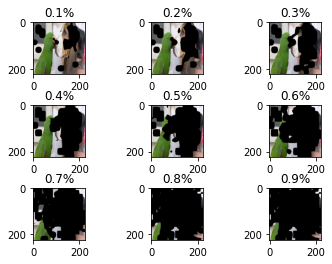

In [130]:
logits_mask = masks[22].median(dim=0)[0]
perbutation(model=model, vis=logits_mask, pic=pic, target_class=target_class)

probability_mask = masks[22]
perbutation(vis=probability_mask, pic=pic)

# Min prediction loss

Original Image. Top Class: basset, basset hound, Max logits: 10.34, Max prob:: 0.8; Correct class logit: 10.34 Correct class prob: 0.80375
0.1% pixels blacked. Top Class: 161, Max logits: 11.19, Max prob:: 0.83; Correct class logit: 11.19 Correct class prob: 0.82848
0.2% pixels blacked. Top Class: 166, Max logits: 8.57, Max prob:: 0.23; Correct class logit: 8.3 Correct class prob: 0.17364
0.3% pixels blacked. Top Class: 90, Max logits: 5.74, Max prob:: 0.1; Correct class logit: 3.14 Correct class prob: 0.0076
0.4% pixels blacked. Top Class: 88, Max logits: 5.86, Max prob:: 0.13; Correct class logit: 2.58 Correct class prob: 0.00474
0.5% pixels blacked. Top Class: 88, Max logits: 5.35, Max prob:: 0.1; Correct class logit: 0.26 Correct class prob: 0.00062
0.6% pixels blacked. Top Class: 88, Max logits: 7.64, Max prob:: 0.47; Correct class logit: -0.14 Correct class prob: 0.0002
0.7% pixels blacked. Top Class: 611, Max logits: 5.84, Max prob:: 0.12; Correct class logit: -1.01 Correct clas

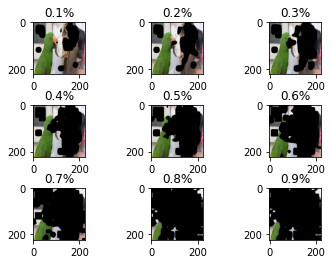

In [131]:
pred_loss_mask = masks[31].median(dim=0)[0]
perbutation(model=model, vis=pred_loss_mask, pic=pic, target_class=target_class)

# Beautiful mask

Original Image. Top Class: basset, basset hound, Max logits: 10.34, Max prob:: 0.8; Correct class logit: 10.34 Correct class prob: 0.80375
0.1% pixels blacked. Top Class: 88, Max logits: 6.67, Max prob:: 0.22; Correct class logit: 2.49 Correct class prob: 0.00341
0.2% pixels blacked. Top Class: 88, Max logits: 7.9, Max prob:: 0.4; Correct class logit: 1.85 Correct class prob: 0.00093
0.3% pixels blacked. Top Class: 88, Max logits: 8.65, Max prob:: 0.47; Correct class logit: -0.13 Correct class prob: 7e-05
0.4% pixels blacked. Top Class: 88, Max logits: 6.66, Max prob:: 0.19; Correct class logit: -0.86 Correct class prob: 0.0001
0.5% pixels blacked. Top Class: 88, Max logits: 7.69, Max prob:: 0.4; Correct class logit: -0.73 Correct class prob: 9e-05
0.6% pixels blacked. Top Class: 88, Max logits: 5.7, Max prob:: 0.11; Correct class logit: -0.48 Correct class prob: 0.00024
0.7% pixels blacked. Top Class: 920, Max logits: 6.96, Max prob:: 0.33; Correct class logit: -0.49 Correct class pro

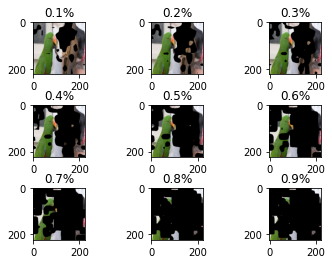

In [132]:
beautiful_mask = masks[172].median(dim=0)[0]
perbutation(model=model, vis=beautiful_mask, pic=pic, target_class=target_class)

Original Image. Top Class: basset, basset hound, Max logits: 10.34, Max prob:: 0.8; Correct class logit: 10.34 Correct class prob: 0.80375
0.1% pixels blacked. Top Class: 88, Max logits: 6.27, Max prob:: 0.17; Correct class logit: 2.66 Correct class prob: 0.00461
0.2% pixels blacked. Top Class: 88, Max logits: 7.85, Max prob:: 0.44; Correct class logit: -0.64 Correct class prob: 9e-05
0.3% pixels blacked. Top Class: 88, Max logits: 7.37, Max prob:: 0.38; Correct class logit: -0.88 Correct class prob: 0.0001
0.4% pixels blacked. Top Class: 88, Max logits: 5.88, Max prob:: 0.12; Correct class logit: -0.75 Correct class prob: 0.00016
0.5% pixels blacked. Top Class: 88, Max logits: 5.72, Max prob:: 0.11; Correct class logit: -0.79 Correct class prob: 0.00017
0.6% pixels blacked. Top Class: 88, Max logits: 7.06, Max prob:: 0.31; Correct class logit: -0.71 Correct class prob: 0.00013
0.7% pixels blacked. Top Class: 920, Max logits: 7.51, Max prob:: 0.41; Correct class logit: -0.45 Correct cl

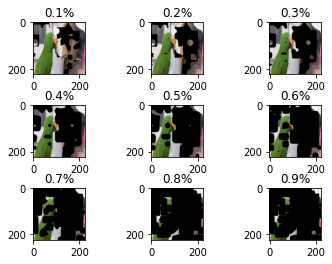

In [133]:
visu(pic, end_mask, 'end_mask')
end_mask = masks[-1].median(dim=0)[0]
perbutation(model=model, vis=end_mask, pic=pic, target_class=target_class)

In [134]:
t = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [137]:
torch.topk(t, k=5, largest=False)

torch.return_types.topk(
values=tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000]),
indices=tensor([0, 1, 2, 3, 4]))

In [59]:
from sklearn.metrics import roc_auc_score, auc

In [7]:
0.39 + 0.4

0.79

In [11]:
roc_auc_score

In [67]:
a = np.array([0,1,1,0])

In [69]:
np.argwhere(a == 0).flatten()

array([0, 3], dtype=int64)

In [90]:
100 * auc(x=np.arange(0, 1, 0.1), y=np.array([1, 0.6 ,0.4, 0.2, 0. , 0. , 0. , 0.,  0., 0. ]))

17.0

In [72]:
a = [1, 0.57957958, 0.38738739, 0.26426426, 0.17717718, 0.09309309, 0.03903904, 0.00900901, 0.         ,0.        ]

In [73]:
100 * auc(x=np.arange(0, 1, 0.1), y=np.array(a))

20.4954955

In [15]:
import numpy as np

In [46]:
len([0.4, 0.4, 0.,  0.,  0.,  0.,  0.,  0.,0.])

9

In [48]:
len(np.arange(0, 1, 0.1))

10

In [58]:
np.trapz([0.4, 0.4, 0.,  0.,  0.,  0.,  0.,  0.,0.], np.arange(0, 0.9, 0.1)) * 100

0.06000000000000001

In [63]:
rollout_acc.in

array([0.80314, 0.77656, 0.7576 , 0.72918, 0.6846 , 0.6228 , 0.53898,
       0.43206, 0.29894, 0.13482])

In [64]:
np.insert(rollout_acc, 0, 1)

array([1.     , 0.80314, 0.77656, 0.7576 , 0.72918, 0.6846 , 0.6228 ,
       0.53898, 0.43206, 0.29894, 0.13482])

In [40]:
rollout_acc = np.array([0.80314, 0.77656, 0.7576, 0.72918, 0.6846, 0.6228, 0.53898, 0.43206, 0.29894, 0.13482])
np.trapz(rollout_acc, np.arange(0, 1, 0.1)) * 100

53.09700000000001

In [55]:
np.trapz(np.array(-8.569156426876784 2.442375320111895), np.arange(0, 1, 0.1)) * 100

53.09700000000001

In [101]:
torch.argmax(t, dim=1)

tensor([742, 129, 522,  95,  77, 648, 245, 413, 136, 263, 437, 651, 615, 828,
        533, 742])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
ours_50_pictures = np.array([1, 0.44, 0.26, 0.2, 0.1, 0.06, 0.04, 0, 0, 0])
lior_50_pictures = np.array([1, 0.48, 0.3, 0.2, 0.06, 0.06, 0, 0, 0, 0])
x = np.arange(0, 1, 0.1)

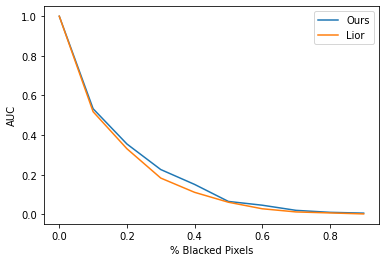

In [4]:
plt.plot(x, ours_1000_pictures)
plt.plot(x, lior_1000_pictures)
plt.legend(['Ours', 'Lior'])
plt.xlabel('% Blacked Pixels')
plt.ylabel('AUC')
plt.show()
ours_1000_pictures = np.array([1, 0.533, 0.355, 0.226, 0.151, 0.065, 0.046, 0.02, 0.01, 0.006])
lior_1000_pictures = np.array([1, 0.518, 0.331, 0.183, 0.111, 0.061, 0.028, 0.012, 0.007, 0.002])